In [211]:
import cv2
import numpy as np
import  matplotlib.pyplot as plt
import os, sys
import time
# Add the parent directory (one level up) to the Python path
parent_dir = os.path.abspath(os.path.join(os.getcwd(), os.pardir))
sys.path.insert(0, parent_dir)

import warnings
warnings.filterwarnings("ignore")

from modules.inference import preprocessing, object_detection, nms

### Load the two models ###

In [11]:
#load model 1 and model 2
yolo_model1 = object_detection.Model()
yolo_model2 = object_detection.Model('../storage/models/yolo_model_2/yolov4-tiny-logistics_size_416_2.weights', 
                               '../storage/models/yolo_model_2/yolov4-tiny-logistics_size_416_2.cfg',
                               '../storage/models/yolo_model_2/logistics.names')

In [72]:
#model classes
labels = yolo_model1.classes

### Organize data and function to load ground truth data ###

In [164]:
#organize dataset to run inference.
data_dir = '../storage/data/dataset'
data_paths = os.listdir(data_dir)
image_paths = [os.path.join(data_dir, x) for x in data_paths if x.endswith('.jpg')]
bbox_paths = [os.path.join(data_dir, x) for x in data_paths if x.endswith('.txt')]

#get image and bounding boxes
def load_image_and_bbox(image_dir):

    #bounding box dir
    bbox_dir = image_dir.replace('.jpg', '.txt')

    #laod image
    image = cv2.imread(image_dir)
    
    #load the corresponding ground truth bounding box path
    with open(bbox_dir, 'r') as f:
        bboxes = f.readlines()

    #list to capture data
    ground_truth_boxes = []
    classes = []
    confidence = []
    class_labels = []

    #processes the boundary box data
    for bbox in bboxes:
        bbox_split = bbox.split(' ')
        classes.append(int(bbox_split[0]))
        bbox_float = [float(x) for x in bbox_split[1:]]        
        ground_truth_boxes.append(bbox_float)
        confidence.append(100)
        class_labels.append(labels[int(bbox_split[0])])

    #preprocess image using the same pipeline used before
    image_processed = cv2.dnn.blobFromImage(image,
                        scalefactor = 1/255.,
                        size = (416, 416),
                        mean = (0, 0, 0),
                        swapRB = True,
                        crop = False
    )
    
    return image_processed, ground_truth_boxes, classes, confidence, class_labels

#predict using model
def yolo_predict(model, image, score_threshold = 0.5, nms_iou_threshold = 0.5):

    #predict from model
    predicted_outputs = model.predict(image)
    bounding_boxes, class_categories, scores = model.post_process(predicted_outputs, score_threshold = score_threshold)
       
    #nms
    indices = nms.filter(bounding_boxes, scores, score_threshold=0.0, nms_iou_threshold=nms_iou_threshold)

    filtered_boxes = [bounding_boxes[x] for x in indices]
    filtered_scores = [scores[x] for x in indices]
    filtered_categories = [class_categories[x] for x in indices]    


    return filtered_boxes, filtered_categories, filtered_scores

def center_to_corners(cx, cy, width, height):
    """
    Convert a bounding box from center format (cx, cy, width, height) to
    corner format (x1, y1, x2, y2).
    """
    x1 = cx - width / 2
    y1 = cy - height / 2
    x2 = cx + width / 2
    y2 = cy + height / 2
    return (x1, y1, x2, y2)

def calculate_iou(box1, box2):
    """
    Calculate IoU from bounding boxes given in center format (cx, cy, width, height).
    """
    # Convert center format (cx, cy, w, h) to corner format (x1, y1, x2, y2)
    x1_box1, y1_box1, x2_box1, y2_box1 = center_to_corners(*box1)
    x1_box2, y1_box2, x2_box2, y2_box2 = center_to_corners(*box2)

    # Calculate the coordinates of the intersection rectangle
    x1_inter = max(x1_box1, x1_box2)
    y1_inter = max(y1_box1, y1_box2)
    x2_inter = min(x2_box1, x2_box2)
    y2_inter = min(y2_box1, y2_box2)

    # Calculate the area of the intersection rectangle
    inter_width = max(0, x2_inter - x1_inter)
    inter_height = max(0, y2_inter - y1_inter)
    inter_area = inter_width * inter_height

    # Calculate the area of both bounding boxes
    box1_area = (x2_box1 - x1_box1) * (y2_box1 - y1_box1)
    box2_area = (x2_box2 - x1_box2) * (y2_box2 - y1_box2)

    # Calculate the area of the union (total area minus intersection area)
    union_area = box1_area + box2_area - inter_area

    # Avoid division by zero by ensuring union_area > 0
    if union_area == 0:
        return 0.0

    # Compute the IoU
    iou = inter_area / union_area
    return iou

### Create a method to evalutate results ###

In [ ]:
def evaluate_predictions(gt_boxes, gt_categories, pred_boxes, pred_categories, iou_threshold=0.5):
    """
    Evaluate predictions with IoU and category matching.
    """
    TP = 0  # True Positives
    FP = 0  # False Positives
    FN = 0  # False Negatives
    
    # Track which ground truth boxes are matched
    matched_gt = [False] * len(gt_boxes)
    
    # For each predicted box, find the best matching ground truth box
    for i, pred_box in enumerate(pred_boxes):
        best_iou = 0
        best_gt_idx = -1
        
        # Find the ground truth box with the highest IoU
        for j, gt_box in enumerate(gt_boxes):
            iou = calculate_iou(pred_box, gt_box)
            if iou > best_iou:
                best_iou = iou
                best_gt_idx = j
        
        # If the best IoU exceeds the threshold and category matches
        if best_iou >= iou_threshold and gt_categories[best_gt_idx] == pred_categories[i]:
            if not matched_gt[best_gt_idx]:
                TP += 1  # True positive (correct detection)
                matched_gt[best_gt_idx] = True  # Mark ground truth as matched
            else:
                FP += 1  # False positive (double prediction for the same object)
        else:
            FP += 1  # False positive (incorrect detection or low IoU)
    
    # Any unmatched ground truth boxes are considered false negatives
    FN = matched_gt.count(False)
    
    # Calculate precision, recall, F1 score
    precision = TP / (TP + FP) if TP + FP > 0 else 0
    recall = TP / (TP + FN) if TP + FN > 0 else 0
    f1_score = (2 * precision * recall) / (precision + recall) if precision + recall > 0 else 0
    
    return {
        'precision': precision,
        'recall': recall,
        'f1_score': f1_score,
        'TP': TP,
        'FP': FP,
        'FN': FN
    }

### Sample image prediction from yolo 1 ###

In [202]:
#ground truth data
image, gt_boxes, gt_classes, gt_confidence, gt_labels = load_image_and_bbox(image_paths[2012])

#get yolo 1 to predict
filtered_boxes1, filtered_categories1, filtered_scores1 = yolo_predict(yolo_model1, image)
filtered_labels1 = [labels[i] for i in filtered_categories1]

# #tranpose image for plotting
image_transposed = np.transpose(image[0], (1, 2, 0))

image = object_detection.draw_multiple_boxes(image_transposed, gt_boxes, gt_confidence, gt_classes, gt_labels, color = (0, 255, 0))
image = object_detection.draw_multiple_boxes(image, filtered_boxes1, filtered_scores1, filtered_categories1, filtered_labels1, color = (255, 0, 0))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


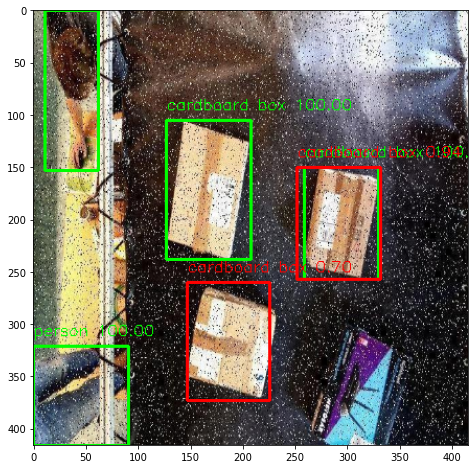

In [203]:
#plot image
plt.figure(figsize = (8, 8))
plt.imshow(image)
plt.show()

In [204]:
#evaulate results
yolo1_results = evaluate_predictions(gt_boxes, gt_classes, filtered_boxes1, filtered_categories1)
for key, value in yolo1_results.items():
    print(f"{key}: {value}")

precision: 0.5
recall: 0.25
f1_score: 0.3333333333333333
TP: 1
FP: 1
FN: 3


### Sample prediction from yolo 2 ###

In [208]:
#ground truth data
image, gt_boxes, gt_classes, gt_confidence, gt_labels = load_image_and_bbox(image_paths[2012])

#get yolo 1 to predict
filtered_boxes2, filtered_categories2, filtered_scores2 = yolo_predict(yolo_model2, image)
filtered_labels2 = [labels[i] for i in filtered_categories2]

# #tranpose image for plotting
image_transposed = np.transpose(image[0], (1, 2, 0))

image = object_detection.draw_multiple_boxes(image_transposed, gt_boxes, gt_confidence, gt_classes, gt_labels, color = (0, 255, 0))
image = object_detection.draw_multiple_boxes(image, filtered_boxes2, filtered_scores2, filtered_categories2, filtered_labels2, color = (255, 0, 0))


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


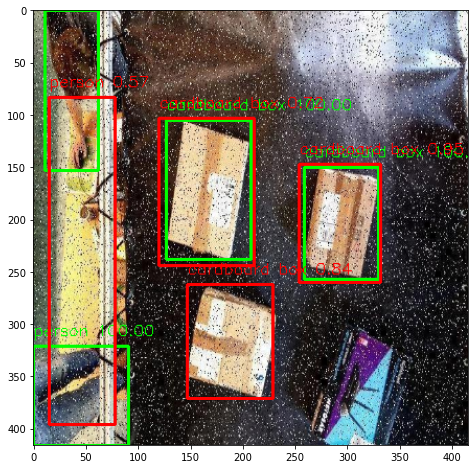

In [209]:
#plot image
plt.figure(figsize = (8, 8))
plt.imshow(image)
plt.show()

In [210]:
#evaulate results
yolo1_results = evaluate_predictions(gt_boxes, gt_classes, filtered_boxes2, filtered_categories2)
for key, value in yolo1_results.items():
    print(f"{key}: {value}")

precision: 0.5
recall: 0.5
f1_score: 0.5
TP: 2
FP: 2
FN: 2


### Use all data to do an analysis ###

In [213]:
# Function to analyze the whole dataset
def analyze_dataset(image_paths, model, score_threshold = 0.5, nms_iou_threshold = 0.5, iou_threshold = 0.5):

    total_tp, total_fp, total_fn = 0, 0, 0
    total_time = 0

    for image_path in image_paths:
        
        # Load image
        image, gt_boxes, gt_classes, gt_confidence, gt_labels = load_image_and_bbox(image_path)
        
        # Time the model prediction
        start_time = time.time()
        #get yolo 1 to predict
        filtered_boxes, filtered_categories, filtered_scores = yolo_predict(model, image, score_threshold = score_threshold, nms_iou_threshold = nms_iou_threshold)
        end_time = time.time()
        
        # Calculate time taken for inference
        inference_time = end_time - start_time
        total_time += inference_time
        
        # Classify predictions for this image
        results = evaluate_predictions(gt_boxes, gt_classes, filtered_boxes, filtered_categories, iou_threshold)
        
        # Accumulate results
        total_tp += results['TP']
        total_fp += results['FP']
        total_fn += results['FN']

    # Calculate metrics after processing all images
    precision = total_tp / (total_tp + total_fp) if (total_tp + total_fp) > 0 else 0
    recall = total_tp / (total_tp + total_fn) if (total_tp + total_fn) > 0 else 0
    f1_score = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0
    avg_time_per_image = total_time / len(image_paths)
    
    return {
        "precision": precision,
        "recall": recall,
        "f1_score": f1_score,
        "avg_time_per_image": avg_time_per_image
    }

In [214]:
yolo1_results = analyze_dataset(yolo_model1)

KeyboardInterrupt: 